<center><img src="static/logo.png" width=450></center>
<p style="text-align: center; font-family: Comfortaa; font-size: 32px">DFT for the rest of us.</p>
<p style="text-align: center; font-size: 48px">[Tutorial Notebook]</p>

# Introduction

In the last few decades, thousands of Ph.D.'s have been given to hard-working theoreticians who solved
complex scientific problems using density functional theory (DFT) codes that they don't really
understand. Pyrho exists to make the "under-the hood" foundation for most DFT codes accessible to
those of us who aren't brave enough to dive into the source code of research grade DFT software packages.

In this tutorial notebook, you will be guided through the process of building `pyrho` from scratch (starting with the 1D Schroedinger equation). To be as nimble and powerful as possible, `pyrho` makes heavy use of numerical recipes and routines in the `numpy` and `scipy` libraries. A working knowledge of the python language and these numerical libraries will therefore be very useful, but not strictly necessary. Along the way, we will make brief remarks about the usage of many important routines and do our best to visualize important features graphically with `matplotlib`.

Happy calculating!

-the pyrho team

# Required Packages
Try running the cell below (shift + enter). If any of the packages cannot be imported, you will need to install it before you can complete this tutorial. Some of the packages, namely `matplotlib` and `skimage`, are just there to help us visualize 2D and 3D data, so they are not technically required (but will be very helpful).

To install `pseudo_dojo` (for pseudopotentials):

```bash
git clone https://github.com/abinit/pseudo_dojo.git
cd pseudo_dojo
python setup.py install
```

In [4]:
import os
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.sparse.linalg import eigsh, LinearOperator
from scipy.spatial.distance import cdist, pdist
from scipy.stats import norm
from skimage.measure import marching_cubes_lewiner
from pseudo_dojo.core.pseudos import Pseudo
from pseudo_dojo.ppcodes.oncvpsp import OncvOutputParser

---
# The Schroedinger equation in 1D

We'll start with the very famous (time-independent) Schroedinger equation,

<center>
$\hat{H}\Psi = E\Psi$,
</center>
    
where the hamiltonian $\hat{H}$ is an operator that has both a kinetic contribution, which we calculate using the laplace operator $-\frac{1}{2}\nabla^2$, and a potential contribution $\nu_{pot}$, which is defined by some external potential.

That means we can rewrite the Schroedinger equation as

<center>
$(-\frac{1}{2}\nabla^2 + \nu_{pot})\Psi = E\Psi$.
</center>

## Calculating $\nabla^2$

Let's start by talking about the laplace operator, $\nabla^2$. This operator sums the second-order partial derivatives of a function. For now, we are talking about a 1D function (our wavefunction $\Psi$), so 

<center>
$\nabla^2 = \frac{\delta^2\Psi}{\delta x^2} $.
</center>

To calculate the laplace operator numerically for a curve with an arbitrary shape, we can use the *finite-difference* method:

<center>
$\nabla^2_i = \frac{\Psi_{i-1}+\Psi_{i+1} - 2\Psi{i}}{\delta x^2} $.
</center>

The function below implements this equation for an evenly spaced function- try running it for yourself.

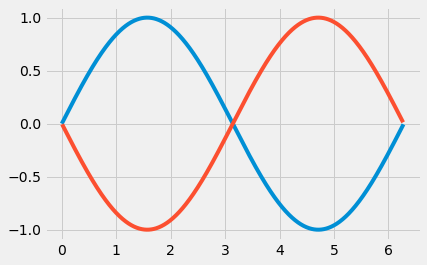

In [5]:
def get_laplacian(psi, dx):
    laplace = []
    for i in range(1, len(psi)-1):
        laplace.append((psi[i-1] + psi[i+1] - 2*psi[i]) / dx**2)
    return laplace
x, dx = np.linspace(0, 2*np.pi, 1000, endpoint=False, retstep=True)
psi = np.sin(x)
plt.plot(x, psi)
plt.plot(x[1:-1], get_laplacian(psi, dx))

You probably noticed that we had to leave out the endpoints for the laplacian because of the way we implemented our operator. If we know that
our wavefunction is periodic, we can solve this problem by rolling values that go beyond the range of `y` back to the beginning of `y`. The modulo
operator `%` would be one way to do this, but `numpy` offers an even more elegant solution in its `roll` function. `numpy.roll` shifts the values in
an array or list forward or backward, and "rolls" indices that go outside the end of the array back to the beginning. That means we don't even have to
write a `for` loop:

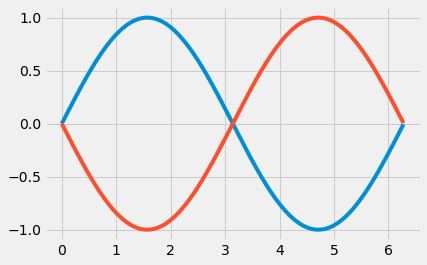

In [6]:
def get_laplacian(psi, dx):
    return (np.roll(psi, 1) + np.roll(psi, -1) - 2*psi)/dx**2

x, dx = np.linspace(0, 2*np.pi, 1000, endpoint=False, retstep=True)
psi = np.sin(x)
plt.plot(x, psi)
plt.plot(x, get_laplacian(psi, dx))

## Calculating $\hat{H}$

We can define any arbitrary shape for the potential $\nu_{pot}$, and most quantum mechanics courses will start with a step function (aka particle-in-a-box).
Below we will use only a slightly-more-realistic *periodic* potential- a cosine wave.

Unlike the laplacian, which was an operator that *acts* on the wavefunction $\Psi$, the potential is a matrix (1D for now) by which the wavefunction is
simply *multiplied*.

So if we use a cosine wave as our $\nu_{pot}$, and recycle the laplacian function we have above, we can write a very simple function to get the overall hamiltonian for our system:

```python
def get_potential(x):
    return np.cos(x)

def get_laplacian(psi, dx):
    return (np.roll(psi, 1) + np.roll(psi, -1) - 2*psi)/dx**2

def get_ham_psi(psi, x, dx):
    return -0.5 * get_laplacian(psi, dx) + get_potential(x) * psi
```

## Solving the eigenvalue problem for one state

Now we have an *eigenvalue problem*. The combinations of $\Psi$ and $E$ that satisfy the conditions imposed by our hamiltonian $\hat{H}$ are called eigenvectors and eigenvalues, respectively. The eigenvectors will be our wavefunctions, and the eigenvalues will be their associated energies.

But we can't calculate the eigenpairs until we have the hamiltonian, and we can't calculate the hamiltonian until we have the eigenpairs! This is a non-linear problem, and numerically we can only solve it via *self-consistency*.

That means we need to start with a guess for our eigenvector (aka wavefunction), $\Psi_{trial}$. We can use $\Psi_{trial}$ to calculate both sides of the Schroedinger equation, and take the difference between the two as a residual $e$:

<center>
    $e = \hat{H}\Psi - E\Psi$.
</center>
    
If we multiply $e$ and $\Psi$, we can use the product as a kind of "force" acting on $\Psi$ to pull it closer to the true $\Psi$ that has the lowest energy- the actual eigenvector. We will actually use this force in an equation of motion to update $\Psi$, but to avoid eternally oscillating around the minimum as we approach it, we need to include some damping, or friction, into our equation of motion. Let's call this friction $\alpha$; then our equation to update $\Psi$ is

<center>
    $\Psi_{new} = \Psi_{trial} + \alpha e\Psi$.
</center>

Then we just repeat this procedure using the updated $\Psi$ as our new $\Psi_{trial}$ until the magnitude of the residual is below a specified convergence threshold.

Translating all of this into Python looks something like this:

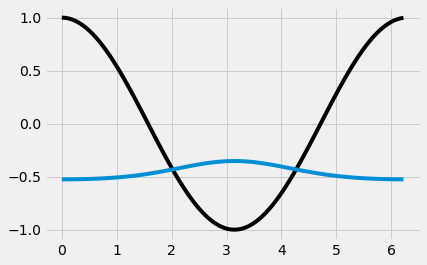

In [7]:
def get_potential(x):
    return np.cos(x)

def get_laplacian(psi, dx):
    return ((np.roll(psi, -1) + np.roll(psi, 1) - 2 * psi) / dx**2.)

def get_ham_psi(psi, x, dx):
    return (-0.5 * get_laplacian(psi, dx) + get_potential(x)*psi)

def get_energy(psi, x, dx):
    return np.dot(psi, get_ham_psi(psi, x, dx))

def get_residual(psi, x, dx): 
    return get_ham_psi(psi, x, dx) - get_energy(psi, x, dx)*psi

def update_psi(psi, x, dx, alpha):
    return normalize(psi + alpha * get_residual(psi, x, dx))

def normalize(psi):
    return psi / np.linalg.norm(psi)

def sc_minimize(psi, x, dx, alpha=-0.001, threshold=1e-4, max_steps=20000):
    for i in range(max_steps):
        psi = update_psi(psi, x, dx, alpha)
        residual = get_residual(psi, x, dx)
        energy = get_energy(psi, x, dx)
        if np.linalg.norm(residual) < threshold:
            return psi, energy
    print (f"Failed to reach threshold within {max_steps} steps. Try either increasing steps or tweak alpha")


x, dx = np.linspace(0, 2*np.pi, 100, endpoint=False, retstep=True)
psi_trial = np.random.rand(x.size)

ax = plt.figure().gca()
psi, E = sc_minimize(psi_trial, x, dx)
ax.plot(x, get_potential(x), color="black")
ax.plot(x, psi+E)

We just solved the Schroedinger equation using about 25 lines of code! The blue line above is the first eigenstate of our system, and the blue line is the potential $\nu_{pot}$. 

Try playing around with the variables in the cell above. You can change the shape of the potential to, e.g. a 1D step function.

## Solving the eigenvalue problem for multiple states

The problem with our current definition for updating $\Psi_{trial}$ is that we can't force our residual-based minimization procedure to end anywhere except the overall minimum- the first state. If we added new states right now, e.g. more electrons, they would also minimize to the exact same wavefunction as the first one. Somehow we have to force the minimization procedure to land on a unique eigenpair for each state.

To force our minimization to reach a unique $\Psi$, we have to orthogonalize each new $\Psi$ and its residual $e$ to each of the already-converged $\Psi$ for the lower states:

```python
def orthogonalize(psi, eigenvectors):
    for ev in eigenvectors:
        psi -= np.dot(psi, ev) * ev
    return psi
```

We can simply modify the setup from the previous cells to include an `orthogonalize()` function, and then wrap our `get_residual()` and `update_psi()` functions to include this orthogonalization. Then we just need to store the converged wavefunctions somewhere, and repeat the self-consistent cycle for however many states we want:

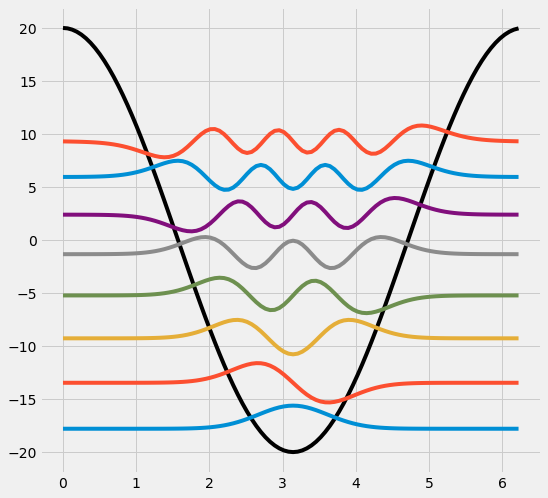

In [8]:
def get_potential(x):
    return 20*np.cos(x)

def get_laplacian(psi, dx):
    return ((np.roll(psi, -1) + np.roll(psi, 1) - 2 * psi) / dx**2.)

def get_ham_psi(psi, x, dx):
    return (-0.5 * get_laplacian(psi, dx) + get_potential(x)*psi)

def get_energy(psi, x, dx):
    return np.dot(psi, get_ham_psi(psi, x, dx))

def get_residual(psi, x, dx, eigenvectors): 
    return orthogonalize(get_ham_psi(psi, x, dx) - get_energy(psi, x, dx)*psi, eigenvectors)

def update_psi(psi, x, dx, alpha, eigenvectors):
    return normalize(orthogonalize(psi + alpha * get_residual(psi, x, dx, eigenvectors), eigenvectors))

def normalize(psi):
    return psi / np.linalg.norm(psi)

def orthogonalize(psi, eigenvectors):
    for ev in eigenvectors:
        psi -= np.dot(psi, ev) * ev
    return psi

def sc_minimize(psi, x, dx, eigenvectors, alpha=-0.001, threshold=1e-4, max_steps=20000):
    for i in range(max_steps):
        psi = update_psi(psi, x, dx, alpha, eigenvectors)
        residual = get_residual(psi, x, dx, eigenvectors)
        energy = get_energy(psi, x, dx)
        if np.linalg.norm(residual) < threshold:
            return psi, energy
    print (f"Failed to reach threshold within {max_steps} steps. Try either increasing max_steps or tweak alpha")
    return psi, energy

x, dx = np.linspace(0, 2*np.pi, 100, endpoint=False, retstep=True)
psi_trial = np.random.rand(x.size)
n_states = 8
scale = 8. # Just to see the waves more easily
eigenvectors, eigenvalues = [], []

for n in range(n_states):
    psi, E = sc_minimize(psi_trial, x, dx, eigenvectors)
    eigenvectors.append(psi)
    eigenvalues.append(E)
        
ax = plt.figure(figsize=(8, 8)).gca()
ax.plot(x, get_potential(x), color="black")
for n in range(n_states):
    ax.plot(x, eigenvectors[n] * scale + eigenvalues[n])

# Building a Python Class

So far, we've been recycling a lot of code and wasting quite a bit of space by re-declaring variables and functions every time we want to solve the Schroedinger equation.

It would be much more efficient to create a Python class that stores all of the variables and functions for us, and we just create a new instance of the class each time we want to solve for a set of wavefunctions. If you're not familiar with Python classes, [you can find a quick crash course here](https://www.w3schools.com/python/python_classes.asp).

First, we need to initialize the class by storing our basic variables as *attributes* of the class:

```python
class Schroedinger_1D:
    def __init__(self, x_max=np.pi, resolution=100, potential=np.sin, scale=-20, n_states=5, threshold=1e-5, max_steps=2e4):
        self.resolution = resolution
        self.x_max = x_max
        self.x, self.dx = np.linspace(0, x_max, resolution, endpoint=False, retstep=True)
        self.potential = scale*potential(self.x)
        self.n_states = n_states
        self.threshold = threshold
        self.max_steps = max_steps
        self.eigenvectors = []
```

These are all the things we were recycling above:
- `resolution` (int): the number of mesh points on which we will numerically store our potentials and hamiltonian.
- `x_max` (float or int): the maximum grid point.
- `x` and `dx` (float, float): `x` are the actual grid points on the 1D mesh defined by `resolution`, and `dx` is their spacing from one another. These are created inside the class automatically based on the provided `resolution` and `x_max`.
- `potential` (function): the potential to use. We will provide this as a python function without parentheses, e.g. `np.sin`.
- `scale` (float or int): a scalar by which to scale `potential`.
- `n_states` (int): the number of eigenstates we will solve for.
- `threshold` (float or int): the cutoff for convergence in the residual magnitude.
- `max_steps` (int): maximum number of self-consistent steps to run before giving up.
- `eigenvectors` (list): an empty list in which we will store our eingenvectors.

Then, we need to give our class all of the functions we used above, by storing them as *methods* within the class:

```python
class Schroedinger_1D:
    def __init__(self, x_max=np.pi, resolution=100, potential=np.sin, scale=-20, n_states=5, threshold=1e-5, max_steps=2e4):
        self.resolution = resolution
        self.x_max = x_max
        self.x, self.dx = np.linspace(0, x_max, resolution, endpoint=False, retstep=True)
        self.potential = scale*potential(self.x)
        self.n_states = n_states
        self.threshold = threshold
        self.max_steps = max_steps
        self.eigenvectors = []

    def initialize_psi(self):
        return np.random.rand(self.x.size)
        
    def get_laplacian(self, psi):
        return (np.roll(psi, 1) + np.roll(psi, -1) - 2 * psi) / self.dx**2        

    def get_ham_psi(self, psi):
        return -0.5 * self.get_laplacian(psi) + self.potential * psi
    .
    .
    .
```

The class below has all of this built-in, plus a `plot()` method to show the eigenstates:

In [9]:
class Schroedinger_1D:
    def __init__(self, x_max=2*np.pi, resolution=100, potential=np.cos, alpha=-0.001, scale=20, n_states=5, threshold=1e-5, max_steps=20000):
        self.resolution = resolution
        self.x, self.dx = np.linspace(0, x_max, resolution, endpoint=False, retstep=True)
        self.potential = scale*potential(self.x)
        self.alpha = alpha
        self.n_states = n_states
        self.threshold = threshold
        self.max_steps = max_steps
        self.eigenvectors, self.eigenvalues = [], []
            
    def initialize_psi(self):
        return np.random.rand(self.x.size)
            
    def get_laplacian(self, psi):
        return (np.roll(psi, 1) + np.roll(psi, -1) - 2 * psi) / self.dx**2        

    def get_ham_psi(self, psi):
        return (-0.5 * self.get_laplacian(psi) + self.potential * psi)

    def get_energy(self, psi):
        return np.dot(psi, self.get_ham_psi(psi))

    def get_residual(self, psi): 
        return self.orthogonalize(self.get_ham_psi(psi) - self.get_energy(psi)*psi)

    def update_psi(self, psi):
        return normalize(self.orthogonalize(psi + self.alpha * self.get_residual(psi)))

    def normalize(psi):
        return psi / np.linalg.norm(psi)

    def orthogonalize(self, psi):
        for ev in self.eigenvectors:
            psi -= np.dot(psi, ev) * ev
        return psi

    def sc_minimize(self, psi):
        for i in range(self.max_steps):
            psi = self.update_psi(psi)
            residual = self.get_residual(psi)
            energy = self.get_energy(psi)
            if np.linalg.norm(residual) < self.threshold:
                return psi, energy
        print (f"Failed to reach threshold within {self.max_steps} steps. Residual is still {np.linalg.norm(residual)}. Try either increasing max_steps or tweak alpha")
        return psi, energy

    def converge_all_states(self):
        for n in range(self.n_states):
            psi = self.initialize_psi()
            psi, energy = self.sc_minimize(psi)
            self.eigenvectors.append(psi)
            self.eigenvalues.append(energy)
    
    def plot(self):
        ax = plt.figure(figsize=(8, 8)).gca()
        ax.plot(self.x, self.potential, 'k')
        for i in range(self.n_states):
            ax.plot(self.x, self.eigenvectors[i]*8 + self.eigenvalues[i])
        plt.show()

Now it's much easier and cleaner to use our class. The cell below will give the same result as we achieved above, but is much easier to edit and interpret.

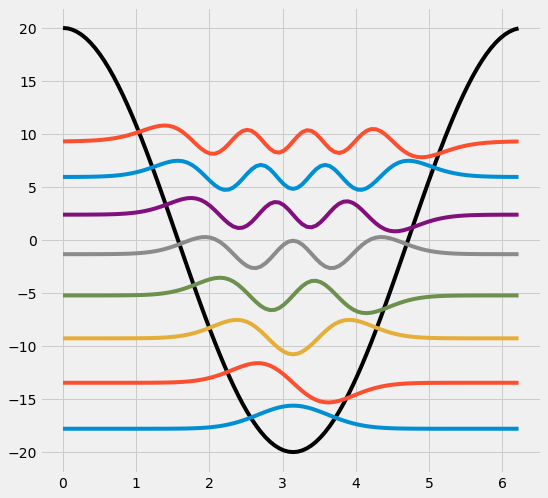

In [10]:
my_schroedinger = Schroedinger_1D(n_states=8)
my_schroedinger.converge_all_states()
my_schroedinger.plot()

# Speeding things up with `scipy`

Try changing `n_states` in the cell above to 12. It will probably not converge, and even if it does, its execution is still very slow (and this is still only one atom!).

Before we move on to more realistic systems, we really need more stability and speed. The good news is we can achieve both by using built-in functions from `scipy`.

The `scipy.sparse.linalg.eigsh()` function returns the eigenvalues and eigenvectors of a matrix automatically (sparing us all of this `alpha`, `threshold`, etc., and even initializing an initial `psi` for us under the hood).

Conveniently, the matrix we want to give to `eigsh()`, $\hat{H}\Psi$, is filled with mostly just zeros. That means it can be more efficiently represented and manipulated by Python as a *sparse* array. And `scipy.sparse.linalg.LinearOperator` lets us convert our $\hat{H}\Psi$ to a sparse array.

We can therefore replace almost all of the methods in the class above with a single `solve()` function:

```python
    def solve(self):
        A = LinearOperator((self.resolution, self.resolution), self.get_ham_psi)
        eigenvalues, eigenvectors = eigsh(A, which='SA', k=self.n_states)
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors.T  # transpose the eigenvectors, which come back along the wrong axis
```

The `which='SA'` argument in `eigsh()` tells the eigensolver which eigenvalues to optimize for: "SA" means "smallest algebraic".

(You can always find out more information about any function in a Jupyter notebook by typing the function name followed by 2 question marks, e.g. `eigsh??` in a code cell. This will display the source code for that class or function.)

Our new, simplified class looks like this:

In [11]:
class Schroedinger_1D_scipy:
    def __init__(self, x_max=2*np.pi, resolution=100, potential=np.cos, scale=20, n_states=5):
        self.resolution = resolution
        self.x_max = x_max
        self.x, self.dx = np.linspace(0, x_max, resolution, endpoint=False, retstep=True)
        self.potential = scale*potential(self.x)
        self.n_states = n_states
            
    def get_laplacian(self, psi):
        return (np.roll(psi, 1) + np.roll(psi, -1) - 2 * psi) / self.dx**2        

    def get_ham_psi(self, psi):
        return -0.5 * self.get_laplacian(psi) + self.potential * psi
    
    def solve(self):
        A = LinearOperator((self.resolution, self.resolution), self.get_ham_psi)
        eigenvalues, eigenvectors = eigsh(A, which='SA', k=self.n_states)
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors.T

    def plot(self):
        ax = plt.figure(figsize=(8, 8)).gca()
        ax.plot(self.x, self.potential, 'k')
        for i in range(self.n_states):
            ax.plot(self.x, self.eigenvectors[i]*10 + self.eigenvalues[i])
        plt.show()

Now that we have a much faster solver, let's look at a physically meaningful system: 2 oxygen atoms next to each other*. This system will have 16 states (2 x 8 electrons) and two potential wells (two positive nuclei that bind the electrons).

To build this system, we just need to double `x_max` and specify `n_states=16`. Let's also define a semi-realistic barrier depth for the nuclei via `scale`.

*Technically this is an infinite chain of oxygen-like atoms, because we have periodic boundary conditions via `numpy.roll`.

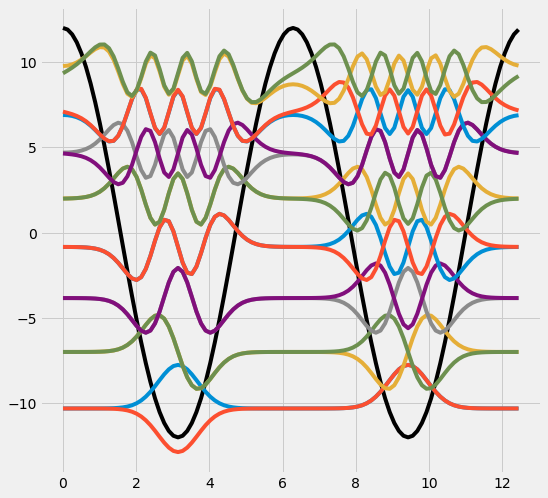

In [12]:
my_schroedinger = Schroedinger_1D_scipy(x_max=4*np.pi, n_states=16, scale=12)
my_schroedinger.solve()
my_schroedinger.plot()

# Physically interpreting this system

You can see in the system above that the densities ($\Psi^2$) for most states are zero between the two atoms, especially the lower states. If we brought these oxygen atoms closer together, the lower states would still not interact. These states represent the oxygens' "core" electrons- they are so strongly bound to the nuclei and localized that they do not participate in any kind of checmical bond. A chemical bond would mean *enhanced* density in the region between the two atoms, which in the fictitious system we've built, does not happen until we get to ~states 13 and higher.

We can also observe bonding (zero nodes between nuclei) and anti-bonding (crosses the eigenvalue between nuclei) states in our system. These two start to become split at higher states, but at lower states they are almost degenerate.

Now try changing `n_states` in the cell above to 24, and leave everything else the same. The highest states in your system now have wavefunctions that are more or less unperturbed by the underlying atomic structure. These electrons can move freely throughout the system- this is analogous to what happens in metallic systems.

---
# Schroedinger equation in 2D

Now that we have an efficient, robust solver for the 1D Schroedinger equation, let's expand into the other dimensions as well. The beauty of using python classes is that in order to go from 1D --> 2D, we only need to change a few lines of code.

Now, instead of solving $\hat{H}\Psi$ on a 1D grid of points, $x$, we want a 2D mesh of points $(x, y)$. This is achieved using the `numpy.meshgrid` object:

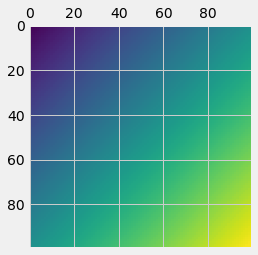

In [13]:
x = np.linspace(0, 2*np.pi, 100)
xx, yy = np.meshgrid(x, x)
plt.matshow(xx+yy)

The other thing to remember is that the laplacian now has to be taken in 2 dimensions, so we need to "roll" $\Psi$ along both its x- and y-axes.

Below, `numpy.ravel()` is used to flatten a 2D array into a 1D array, and `numpy.reshape` is used to do the opposite.

We will switch to a sine wave potential centered at $\frac{\pi}{2}$ to show the 2D eigenvalues more clearly.

In [14]:
class Schroedinger_2D:
    def __init__(self, x_max=np.pi, resolution=100, potential=np.sin, scale=-20, n_states=5):
        self.resolution = resolution
        self.x_max = x_max
        self.x, self.dx = np.linspace(0, x_max, resolution, endpoint=False, retstep=True)
        self.xx, self.yy = np.meshgrid(self.x, self.x)
        self.potential = scale * potential(self.xx) * potential(self.yy)
        self.n_states = n_states
            
    def get_laplacian(self, psi):
        psi = np.reshape(psi, (self.resolution, self.resolution))
        return ((np.roll(psi, 1, axis=0) + np.roll(psi, -1, axis=0) +
                 np.roll(psi, 1, axis=1) + np.roll(psi, -1, axis=1) -
                 4 * psi) / self.dx**2).ravel()

    def get_hamiltonian(self, psi):
        return -0.5 * self.get_laplacian(psi) + self.potential.ravel() * psi
    
    def solve(self):
        A = LinearOperator((self.resolution**2, self.resolution**2), self.get_hamiltonian)
        eigenvalues, eigenvectors = eigsh(A, which='SA', k=self.n_states)
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors.T

    def plot(self):
        fig, ax = plt.subplots(nrows=1, ncols=self.n_states, figsize=(15, 5))
        for i in range(self.n_states):
            ax[i].axis("off")
            ax[i].imshow(np.reshape(self.eigenvectors[i], (self.resolution, self.resolution)))
        plt.show()

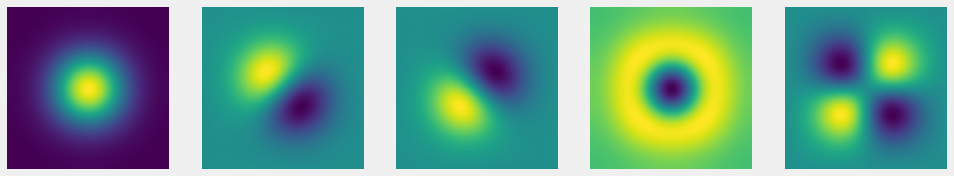

In [15]:
my_schroedinger = Schroedinger_2D()
my_schroedinger.solve()
my_schroedinger.plot()

From the plots above, you can already recognize atomic orbitals (1 $s$, 1 $p_x$ 1 $p_y$, 2 $s$, and 1 $d$). The only
reason there is no $p_z$ orbital is that we haven't included a $z$-dimension!

---
# Schroedinger equation in 3D

Similarly, to extend to 3 dimensions is also straighforward. We just need to

1. extend our numerical mesh from 2D to 3D (which `numpy.meshgrid` can still handle)
2. build a 3D potential
3. roll the laplacian in one more dimension

Don't worry too much about the crazy plotting statements below- plotting with matplotlib in 3D can be messy.

In [16]:
class Schroedinger_3D:
    def __init__(self, x_max=np.pi, resolution=20, potential=np.sin, scale=-30, n_states=8):
        self.resolution = resolution
        self.n_mat = resolution**3  # Stored as a variable to save us some computation
        self.x_max = x_max
        self.x, self.dx = np.linspace(0, x_max, resolution, endpoint=False, retstep=True)
        self.xx, self.yy, self.zz = np.meshgrid(self.x, self.x, self.x)
        self.potential = scale * potential(self.xx) * potential(self.yy) * potential(self.zz)
        self.n_states = n_states
        
    def get_laplacian(self, psi):
        psi = np.reshape(psi, (self.resolution, self.resolution, self.resolution))
        return ((np.roll(psi, 1, axis=0) + np.roll(psi, -1, axis=0) +
                 np.roll(psi, 1, axis=1) + np.roll(psi, -1, axis=1) +
                 np.roll(psi, 1, axis=2) + np.roll(psi, -1, axis=2) +
                - 6 * psi)/self.dx**2).ravel()        
    
    def get_hamiltonian(self, psi):
        return -0.5 * self.get_laplacian(psi) + self.potential.ravel() * psi
    
    def solve(self):
        A = LinearOperator((self.n_mat, self.n_mat), self.get_hamiltonian)
        eigenvalues, eigenvectors = eigsh(A, which='SA', k=self.n_states)
        self.eigenvalues = eigenvalues
        self.eigenvectors = [np.reshape(ev, (self.resolution, self.resolution, self.resolution))
                             for ev in eigenvectors.T]
        
    def plot(self):
        fig = plt.figure(figsize=(20, 20/self.n_states))
        for i in range(self.n_states):
            v = self.eigenvectors[i]
            ax = fig.add_subplot(1, self.n_states, i+1, projection='3d')
            ax.axis("off")
            if i == 0: # i.e. there are no negative values
                verts, faces, normals, values = marching_cubes_lewiner(v, spacing=(0.1, 0.1, 0.1))
                ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=0)
            else:
                level1, level2 = max(v.ravel())*0.2, min(v.ravel())*0.2                
                verts, faces, normals, values = marching_cubes_lewiner(v, level=level1, spacing=(0.1, 0.1, 0.1))
                ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=0)
                verts, faces, normals, values = marching_cubes_lewiner(v, level=level2, spacing=(0.1, 0.1, 0.1))
                ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=0)
        plt.show()

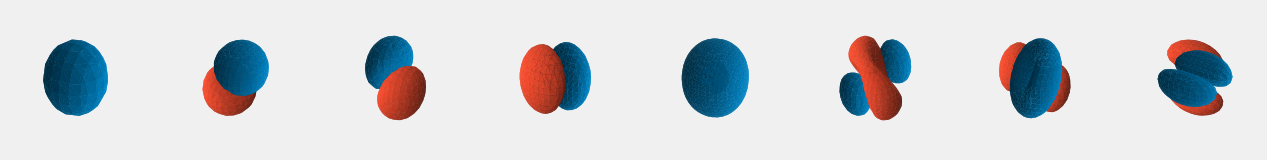

In [17]:
my_schroedinger = Schroedinger_3D()
my_schroedinger.solve()
my_schroedinger.plot()

---

# From Schroedinger to DFT

Now we have the exact ground states and excited states for a system of electrons that don't interact with each other at all, other than that their wavefunctions are orthogonal. But in the real world, electrons interact not only with an external potential (like the sinusoid we created above), but also with other electrons in complex ways. Solving the shape of the potential that arises from these interactions in realistic systems ($N_e ~= 10^{23}$) quickly becomes an unsolvable problem (the many-body problem). Hohenberg and Sham proposed that we can get around this problem by treating a system of interacting electrons the same way we treat a system of non-interacting electrons, but where each electron sees an *effective* potential which accounts for the many-body interactions. Kohn and Sham later proved that by doing this, we can rewrite the Schroedinger equation as

<center>
    $\hat{H}_{ks}(r)\psi_i(r) = \epsilon_i\psi_i(r)$
<\center>

where $\psi_i(r)$ are the orbitals of each non-interacting electron, $\epsilon_i$ are their corresponding eigenvalues, and $\hat{H}_{KS}$ is the new effective Hamiltonian. $\hat{H}_{ks}(r)$ looks very much the same as the Hamiltonian above:

<center>
    $\hat{H}_{ks}(r) = -\frac{1}{2}\nabla^2 + \nu_{eff}(r)$
<\center>
    
The main difference between this representation and the one we had at the beginning is that we've replaced $\nu_{pot}$ with $\nu_{eff}(r)$, where now

<center>
    $\nu_{eff}(r) = \nu_{ext}(r) + \nu_{H}(r) + \nu_{xc}(r)$.
<\center>

    
Let's look at the 3 components of $\nu_{ks}(r)$:

1. $\nu_{ext}(r)$ is an external potential, exactly analogous to the simple $V_{pot}$ potentials we've been using up to this point. The shape of this potential arises from the electron's interaction with positively charged nuclei in the system:


<center>
    $$\nu_{ext}(r) = \sum_i^N{\frac{Z_i}{|r-R_i|}}$$
<\center>

2. $\nu_{H}(r)$ is called the Hartree potential- this term gives us the repulsive interaction between the negatively charged electron density and itself. This can be calculated as the Coulombic interaction of each point $r$ with each other point $r^\prime$ in the density:

<center>
    $\nu_{H}(r) = q^2\int{d^3r^\prime\frac{\rho(r^\prime)}{|r-r^\prime|}}$
<\center>
    
3. $\nu_{xc}(r)$ is the exchange-correlation potential, whose form is not known and must be approximated. The most famous approximations to this potential tell us that $\nu_{xc}(r)$ is (more or less) a function of the local density (the so-called local density approximation, LDA) or its derivatives (generalized gradient approximation, GGA). In the local density approximation, we say
    
<center>
    $\nu_{xc}(r) = \frac{\delta\epsilon^{hom}_{xc}(\rho(r))}{\delta~\rho(r)}$
<\center>

Clearly, we need a density $\rho(r)$ before we can calculate $\nu_{eff}$. But to obtain $\rho(r)$, we need the wavefunctions $\psi_i(r)$ for the relation
    
<center>
    $$\rho(r) = \sum_{i=1}^{N}|\psi_i(r)|^2$$
<\center>
    
The Kohn Sham wavefunctions, $\psi_i(r)$ cannot be determined until we have the full Hamiltonian, which means we need $\nu_{eff}$.
    
It seems like we have a circular problem- $\nu_{eff}(r)$ depends on $\rho(r)$, which depends on $\psi_i(r)$, which depends on $\nu_{eff}(r)$. This kind of non-linear problem has to be solved *self-consistently*.

We start by initializing a trial density, $\rho_0(r)$, and using this density to obtain $\hat{H}_{ks}$, and using this Hamiltonian to obtain wavefunctions, $\psi_i(r)$. From these wave functions, we can calculate the total energy as
    
$$E_{ks} = \sum_{i=1}^{N}{\epsilon_i} + \int{\nu_{ext}(r)\rho(r)dr} + \int{\nu_{H}(r)\rho(r)dr} + \int{\nu_{xc}(r)\rho(r)dr}$$

Let's call the change in this energy between self-consistent steps $\Delta~E$. The more realistic our starting guess for $\rho_0(r)$ is, the faster we will converge $\Delta~E$. In practice, one of the most popular choices for $\rho_0(r)$ is to use the overlapping densities of neutral, non-interacting atoms centered where the system's nuclei are. These densities are usually read in from pseudopotential files.

# Pseudopotentials

We established above for the 1D Schroedinger equation (and you probably already knew) that core electrons don't usually participate in any chemically interesting interactions. Every electron we explicitly include in a DFT calculation will cost us time, so we would like to ignore core electrons as often as possible.

To do this, almost every DFT code uses pseudopotentials. Reading in pseudopotential files actually gives us several distinct advantages:

1. Provides $\nu_{ext}$- also groups an atom's core electrons together with the positively-charged core and modifies $\nu_{ext}$ so that it does not diverge at $|r-R| = 0$.

2. Provides $\nu_{xc}$- this is why you have to choose between LDA or GGA pseudopotentials in most major DFT codes that offer both.

3. Gives us a good choice for the starting charge density, $\rho_0(r)$.

There are many forms of pseudopotentials, designed for many different purposes. The people behind [`pseudo-dojo`](http://www.pseudo-dojo.org/) have put together a very useful python package for building and testing pseudopotentials, and they also provide a lot of their own pseudopotentials that are used in [Abinit](https://www.abinit.org/).

Let's build a simple class to read in one of their pseudopotentials and extract only what we need from it:

In [18]:
class Pseudopotential:
    def __init__(self, element, prefix="/Users/ashton/Software/pseudo_dojo/pseudo_dojo/pseudos/ONCVPSP-PBE-PDv0.4/"):
        filename = os.path.join(prefix, element, "%s.psp8" % element)
        if not os.path.isfile(filename):
            filename = os.path.join(prefix, element, "%s-s.psp8" % element)
        if not os.path.isfile(filename):
            filename = os.path.join(prefix, element, "%s-sp.psp8" % element)
        psp = Pseudo.from_file(filename)
        scanner = OncvOutputParser(filename.replace(".psp8", ".out"))
        scanner.scan()

        self.filename = filename
        self.potentials = scanner.potentials
        self.densities = scanner.densities
        self.Z = psp.Z
        self.n_electrons = psp.Z_val

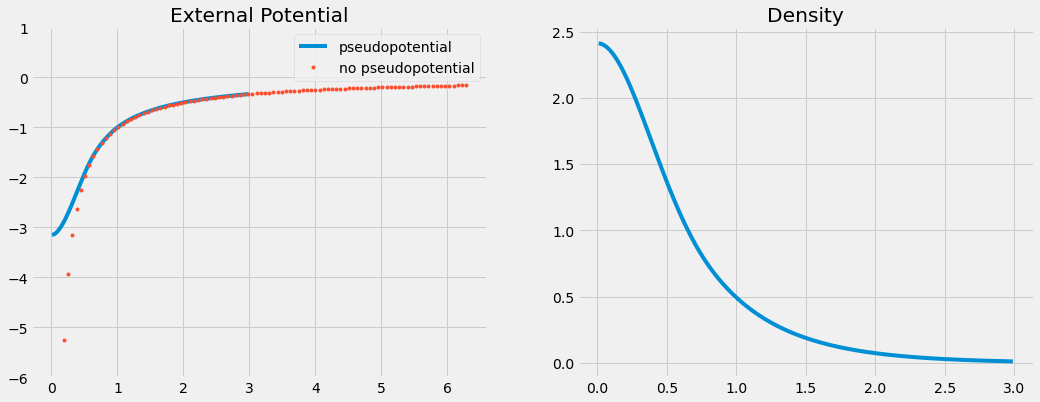

In [24]:
H = Pseudopotential("H")

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].set_title("External Potential")
ax[0].plot(H.potentials[-1].rmesh, H.potentials[-1].values, label="pseudopotential")
ax[0].plot(x, -H.Z / x, label="no pseudopotential", marker=".", linewidth=0)
ax[0].set_ylim(-6, 1)
ax[0].legend()
ax[1].set_title("Density")
ax[1].plot(H.densities["rhoV"].rmesh, H.densities["rhoV"].values)

We can use the `Pseudopotential` object we just made to initialize a DFT calculation based on a few atomic coordinates in 3D, but first let's build the class that would make use of this function.

```python
class DFT:
    def __init__(self, resolution=(10, 10, 10), x_max=10, y_max=10, z_max=10, atoms=None):
        """
        A real-space Kohn-Sham equation solver.
        
        Args:
        `resolution` ((int, int)): number of real-space grid points (x, y) on which to calculate/store densities + potentials
        `x_max` (float): cell length in x-direction
        `y_max` (float): cell length in y-direction
        `z_max` (float): cell length in z-direction
        `atoms` (ase.Atoms): Atoms object from ASE
        """

        self.resolution = resolution
        self.x, self.dx = np.linspace(0, x_max, resolution[0], endpoint=False, retstep=True)
        self.y, self.dy = np.linspace(0, y_max, resolution[1], endpoint=False, retstep=True)
        self.z, self.dz = np.linspace(0, z_max, resolution[1], endpoint=False, retstep=True)
        self.n_mat = np.prod(resolution)
        self.xx, self.yy, self.zz = np.meshgrid(self.x, self.y, self.z)
        self.flat_mesh = np.array(list(zip(self.xx.ravel(), self.yy.ravel(), self.zz.ravel())))
        dm = cdist(self.flat_mesh, self.flat_mesh)
        self.dm = dm[~np.eye(dm.shape[0],dtype=bool)].reshape(dm.shape[0],-1)
        self.E = 0
        self.v_H = np.zeros(self.resolution)
        self.v_xc = np.zeros(self.resolution)
        self.eigenvectors, self.eigenvalues = None, None
        self.atoms = atoms
        self.n_atoms = len(atoms)
        self.coords = []
        self.Zs = []
        for element in atoms:
            for coord in atoms[element]:
                self.coords.append(coord)
                self.Zs.append(Pseudopotential(element).Z)
        self.nn_coulomb_E = 0
        for i in range(len(self.coords)):
            for j in range(len(self.coords)):
                if i != j:
                    Rij = np.linalg.norm(np.subtract(self.coords[i], self.coords[j]))
                    self.nn_coulomb_E += 0.5 * self.Zs[i]*self.Zs[j] / Rij
```

This is a pretty long `__init__()`, but we already have our cell set up and filled with atoms, and we already have the energy due to the coulombic repulsion between the positively-charged nuclei (`self.nn_coulomb_E`). Now let's add a function `self.initialize_pseudopotentials()` to initialize a charge density and $\nu_{ext}$ just by reading in Pseudopotentials based on the atoms we have.

In [20]:
class DFT:
    
    def __init__(self, resolution=(10, 10, 10), x_max=10, y_max=10, z_max=10, atoms=None, max_steps=150, convergence_threshold=1e-4, alpha_mix=0.2):
        """
        A real-space Kohn-Sham equation solver.
        
        Args:
        `resolution` ((int, int)): number of real-space grid points (x, y) on which to calculate/store densities + potentials
        `x_max (float): cell length in x-direction
        `y_max` (float): cell length in y-direction
        `z_max` (float): cell length in z-direction
        `atoms` (dict): element symbols and 3D positions, e.g.
            {"H": [(4, 4, 3), (4, 4, 2)], "O": [(3, 3, 3)]}
        `max_steps` (int): max number of electronic steps before giving up
        `convergence_threshold` (float): criteria for energy convergence
        `alpha_mix` (float): fraction of new density to "mix" with the previous density
        """

        self.resolution = resolution
        self.x, self.dx = np.linspace(0, x_max, resolution[0], endpoint=False, retstep=True)
        self.y, self.dy = np.linspace(0, y_max, resolution[1], endpoint=False, retstep=True)
        self.z, self.dz = np.linspace(0, z_max, resolution[1], endpoint=False, retstep=True)
        self.n_mat = np.prod(resolution)
        self.xx, self.yy, self.zz = np.meshgrid(self.x, self.y, self.z)
        self.flat_mesh = np.array(list(zip(self.xx.ravel(), self.yy.ravel(), self.zz.ravel())))
        dm = cdist(self.flat_mesh, self.flat_mesh)
        self.dm = dm[~np.eye(dm.shape[0],dtype=bool)].reshape(dm.shape[0],-1)
        self.E = 0
        self.v_H = np.zeros(self.resolution)
        self.v_xc = np.zeros(self.resolution)
        self.eigenvectors, self.eigenvalues = None, None
        self.max_steps = max_steps
        self.convergence_threshold = convergence_threshold
        self.alpha_mix = alpha_mix
        self.atoms = atoms
        self.n_atoms = np.sum([len(atoms[atom]) for atom in atoms])
        self.coords = []
        self.Zs = []
        for element in atoms:
            for coord in atoms[element]:
                self.coords.append(coord)
                self.Zs.append(Pseudopotential(element).Z)
        self.nn_coulomb_E = 0
        for i in range(len(self.coords)):
            for j in range(len(self.coords)):
                if i != j:
                    Rij = np.linalg.norm(np.subtract(self.coords[i], self.coords[j]))
                    self.nn_coulomb_E += 0.5 * self.Zs[i]*self.Zs[j] / Rij
        self.initialize_pseudopotentials()
        
    def initialize_pseudopotentials(self):
        self.n_electrons = 0
        self.rho = np.zeros(self.n_mat)
        self.v_ext = np.zeros(self.n_mat)
        for element in self.atoms:
            pseudopotential = Pseudopotential(element)
            for coords in atoms[element]:
                distance_matrix_en = np.array([np.linalg.norm(pt-coords) for pt in self.flat_mesh])

                density = pseudopotential.densities["rhoV"].spline(distance_matrix_en)
                negative_density_indices = density < 0
                density[negative_density_indices] = 0
                self.rho += density
                
                ### [-1] means only the "local" part, i.e. no difference for
                ### varying angular momentum (l)! If you want that then loop over [l].
                potential = pseudopotential.potentials[-1].spline(distance_matrix_en)
                cutoff_indices = potential > 0
                potential[cutoff_indices] = 0
                self.v_ext += potential

                self.n_electrons += int(pseudopotential.n_electrons)
        self.rho = self.rho.reshape(self.resolution)
        self.v_ext = self.v_ext.reshape(self.resolution)
                
    def update_rho(self):
        """
        Update charge density based on previous wavefunctions.
        
        Charge mixing is controlled by alpha_mixing. 
        """
        
        new_rho = np.zeros(self.resolution)
        for n in range(self.n_electrons):
            new_rho += np.power(self.eigenvectors[n], 2)
        delta_rho = new_rho - self.rho
        # Linear mixing:
        self.rho += self.alpha_mix * delta_rho
            
    def update_v_H(self):
        """
        Update hartree potential based on charge density.
        """
        
        v_H = np.zeros(self.n_mat)
        rho = self.rho.ravel()
        for i in range(self.n_mat):
            v_H[i] += 0.5 * np.sum(np.delete(rho, i) / self.dm[i])
        self.v_H = v_H.reshape(self.resolution)
        del v_H
        
    def update_v_xc(self):
        """
        I don't know what I'm doing here- I think this comes straight from the PSP(?)
        """
        self.v_xc = np.zeros(self.resolution)

    def update_v_all(self):
        self.update_v_H()
        self.update_v_xc()
        # v_ext doesn't update since we have no ionic steps.

    def get_laplacian(self, psi):
        psi = np.reshape(psi, self.resolution)
        return ((np.roll(psi, 1, axis=0) + np.roll(psi, -1, axis=0) - 2 * psi)/self.dx**2 +
                (np.roll(psi, 1, axis=1) + np.roll(psi, -1, axis=1) - 2 * psi)/self.dy**2 +
                (np.roll(psi, 1, axis=2) + np.roll(psi, -1, axis=2) - 2 * psi)/self.dz**2).ravel()
        
    def get_hamiltonian(self, psi):
        return -0.5 * self.get_laplacian(psi) + (self.v_ext.ravel() + self.v_H.ravel() + self.v_xc.ravel()) * psi

    def update_wavefunctions(self):
        A = LinearOperator((self.n_mat, self.n_mat), self.get_hamiltonian)
        eigenvalues, eigenvectors = eigsh(A, which='SA', k=self.n_electrons)
        self.eigenvalues = eigenvalues
        self.eigenvectors = [np.reshape(ev, self.resolution) for ev in eigenvectors.T]

    def get_kinetic_energy(self):
        ke = 0
        for eigenvector in self.eigenvectors:
            ke -= np.sum(self.get_laplacian(eigenvector))
        return ke
            
    def get_ext_energy(self):
        return np.sum(self.rho.ravel() * self.v_ext.ravel())

    def get_coulomb_energy(self):
        return
    
    def get_hartree_energy(self):
        return np.sum(self.rho.ravel() * self.v_H.ravel())
        
    def get_xc_energy(self):
        return -0.75 * np.power(3./np.pi, 1./3.) * np.sum(np.power(self.rho, 4./3.))
        
    def update_energy(self):
        self.E = np.sum(self.eigenvalues) + self.nn_coulomb_E
        #self.E = self.get_kinetic_energy() + self.get_ext_energy() + self.get_hartree_energy() + self.nn_coulomb_E
        
    def sc_minimize(self, verbose=False):
        self.update_v_all()
        if verbose:
            print("n       E                  dE")
        self.steps, self.delta_Es = [], []
        for i in range(self.max_steps):
            previous_E = self.E
            self.update_wavefunctions()
            self.update_rho()
            self.update_v_all()
            self.update_energy()
            self.steps.append(i)
            delta_E = self.E - previous_E
            
            n_same = 0
            for prev_delta in self.delta_Es:
                if abs(abs(delta_E) - abs(prev_delta)) < 1e-6:
                    n_same +=1
            if n_same > 4:
                print("Charge appears to be sloshing. Try lowering alpha_mixing")
                break
            self.delta_Es.append(delta_E)
            if verbose:
                print(i+1, self.E, delta_E)
            if abs(delta_E) < self.convergence_threshold:
                self.converged = True
                break
        else:
            self.converged = False
            print(f"WARNING: Convergence ({self.convergence_threshold}) was never reached.")
            
    def plot_rho(self, iso):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.axis("off")
        verts, faces, normals, values = marching_cubes_lewiner(self.rho, level=iso, spacing=(0.1, 0.1, 0.1))
        ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=0)
        plt.show()
        
    def plot_rho2d(self):
        ax = plt.figure(figsize=(8, 8)).gca()
        ax.imshow(self.rho[int(len(self.rho)/2)])
        plt.show()

In [25]:
atoms = {"Ne": [(5, 5, 5)]}
pyrho = DFT(resolution=(10, 10, 10), x_max=10, y_max=10, z_max=10, atoms=atoms, max_steps=100, alpha_mix=0.5)
pyrho.sc_minimize(verbose=True)

n       E                  dE
1 44.702294865421536 44.702294865421536
2 22.370558993916003 -22.331735871505533
3 4.57390703370841 -17.796651960207594
4 -13.981598500576732 -18.555505534285142
5 -20.335522787698515 -6.353924287121783
6 -23.402375423660228 -3.0668526359617125
7 -24.88590432055271 -1.4835288968924836
8 -25.60549814010948 -0.719593819556767
9 -25.955205575615686 -0.34970743550620753
10 -26.125406048650405 -0.1702004730347184
11 -26.208345976571092 -0.0829399279206875
12 -26.248809926066343 -0.04046394949525123
13 -26.268572835189612 -0.019762909123269168
14 -26.278235516355007 -0.009662681165394815
15 -26.2829648424003 -0.004729326045293192
16 -26.285281961105284 -0.002317118704983301
17 -26.286418379060287 -0.0011364179550028553
18 -26.28697628665888 -0.0005579075985941984
19 -26.287250453240055 -0.0002741665811747396
20 -26.287385314892223 -0.0001348616521674728
21 -26.287451716385977 -6.64014937541424e-05


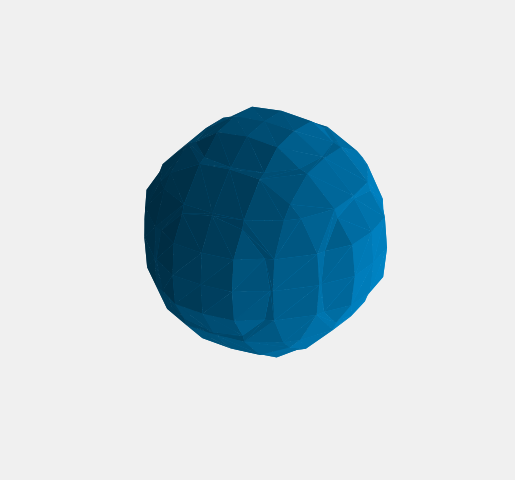

In [22]:
pyrho.plot_rho(0.001)